# Initilizations

In [1]:
import sys
import os
#sys.path.append('../src')
import matplotlib.pyplot as plt
import seaborn as sns
from mpradb.database.mpra_db import MPRA_DB
from copy import deepcopy
from mpradb.db_plot import plot_enrichment, plot_replicates,plot_replicate_heatmap
from mpradb.database.db_to_sqlite import DB_SQLite
from mpradb.db_plot.plot_random_forest import run_models
from mpradb.db_plot import plotter
import pandas as pd

In [2]:


# Importing the SQL database into an MPRA_DB object

db = MPRA_DB(db_path='utr5.db',schema_path='doc/db_schema.sql',output_path=os.getcwd())

# Extracting data from the database

To view the different columns present in the database or to search for specific columns we can do the following:
In this example we want to know the tables that contain columns with the substring `'reporter_group'`

In [24]:
for tab,values in db.table_columns.items():
    if any(['reporter_group' in val for val in values]):
        print(f"Table {tab}:\n Columns: {values}")

Table reporter_group_attribute:
 Columns: ['reporter_group_id', 'reporter_group_type', 'reporter_group_hash', 'reporter_group_name', 'reporter_group_description']
Table reporter_group_to_reporter_group_iso:
 Columns: ['reporter_group_id', 'reporter_group_parent_id']
Table reporter_group_to_data_group_iso:
 Columns: ['reporter_group_id', 'data_group_id']
Table reporter_group_to_reporter_iso:
 Columns: ['reporter_group_id', 'reporter_id']
Table feature_enrichment_iso:
 Columns: ['reporter_group_id', 'feature_id', 'enrichment_pvalue', 'enrichment_fold_change']
Table feature_correlation_iso:
 Columns: ['feature_id', 'reporter_group_id', 'data_group_id', 'correlation', 'pvalue']


We can extract data by calling columns from the `MPRA` object and mentioning the format we would like to obtain.

The library traverses through the schema by joining multiple tables to provide us with the necessary tables/variables.

Few of them can be seen below...

In [ ]:
db[['sample_name']].fetchone() #fetches a single instance of the column

'pa_2hpf'

In [13]:
db[['reporter_group_name']].to_list() #returns a list of the column/s

['polyA_fish',
 'polyA_fish_hek293t',
 'polyA_hek293t',
 'pa_2hpf-translation',
 'pa_2hpf-translation',
 'pa_6hpf-translation',
 'pa_6hpf-translation',
 's1_pa_2hpf-translation-s2_pa_6hpf-translation',
 's1_pa_2hpf-translation-s2_pa_6hpf-translation',
 's1_pa_2hpf-translation-s2_pa_6hpf-translation',
 's1_pa_2hpf-translation-s2_pa_6hpf-translation',
 'pa_2hpf-translation',
 'pa_2hpf-translation',
 'pa_6hpf-translation',
 'pa_6hpf-translation',
 'hek293t_12h-translation',
 'hek293t_12h-translation',
 's1_pa_2hpf-translation-s2_pa_6hpf-translation',
 's1_pa_2hpf-translation-s2_pa_6hpf-translation',
 's1_pa_2hpf-translation-s2_pa_6hpf-translation',
 's1_pa_2hpf-translation-s2_pa_6hpf-translation',
 's1_pa_2hpf-translation-s2_hek293t_12h-translation',
 's1_pa_2hpf-translation-s2_hek293t_12h-translation',
 's1_pa_2hpf-translation-s2_hek293t_12h-translation',
 's1_pa_2hpf-translation-s2_hek293t_12h-translation',
 's1_pa_6hpf-translation-s2_hek293t_12h-translation',
 's1_pa_6hpf-translation-s

In [27]:
db[['replicate_id','replicate_name']].to_df()

,replicate_id,replicate_name
0,0,ntrap_utr5_fish_pa-pa_2hpf-B1
1,1,ntrap_utr5_fish_pa-pa_2hpf-B2
2,2,ntrap_utr5_fish_pa-pa_6hpf-B1
3,3,ntrap_utr5_fish_pa-pa_6hpf-B2
4,4,ntrap_utr5_hek293t-hek293t_12h-B1
5,5,ntrap_utr5_hek293t-hek293t_12h-B2
6,6,ntrap_utr5_hek293t-hek293t_12h-B3
7,7,ntrap_utr5_hek293t-hek293t_12h-B4


In [15]:
db[['sample_name','sample_id','data_id']].to_df() #returns Pandas dataframe

,sample_name,sample_id,data_id
0,pa_2hpf,0,0
1,pa_2hpf,0,1
2,pa_6hpf,1,2
3,pa_6hpf,1,3
4,hek293t_12h,2,4
5,hek293t_12h,2,5
6,hek293t_12h,2,6
7,hek293t_12h,2,7


We can perform more complex queries using `"SQL-like"` functions like `where`,`in`, `groupby`, `orderby` etc.

In [20]:
db[['reporter_group_name','reporter_group_id']].where(db['reporter_group_name'].like('%s1%')).to_df()

,reporter_group_name,reporter_group_id
0,s1_pa_2hpf-translation-s2_pa_6hpf-translation,7
1,s1_pa_2hpf-translation-s2_pa_6hpf-translation,8
2,s1_pa_2hpf-translation-s2_pa_6hpf-translation,9
3,s1_pa_2hpf-translation-s2_pa_6hpf-translation,10
4,s1_pa_2hpf-translation-s2_pa_6hpf-translation,17
5,s1_pa_2hpf-translation-s2_pa_6hpf-translation,18
6,s1_pa_2hpf-translation-s2_pa_6hpf-translation,19
7,s1_pa_2hpf-translation-s2_pa_6hpf-translation,20
8,s1_pa_2hpf-translation-s2_hek293t_12h-translation,21
9,s1_pa_2hpf-translation-s2_hek293t_12h-translation,22


## Extracting specific information from the database

In this example. lets try to extract the counts table for each reporter across samples and replicates as well as the translation values ourselves

First lets extract the raw counts from the tables

In [ ]:
counts_df = db[['reporter_id','replicate_id','raw_count','run_id','run_type']].where((db['reporter_group_name'] == 'polyA_fish') & (db['sample_name'] == 'pa_2hpf')).to_df()

tag_df = db[['reporter_id','tags']].to_df() # we fetch the tables seperately (to prevent maximum recursion) and then merge them

counts_df = counts_df.merge(tag_df,on = 'reporter_id')
counts_df



,reporter_id,replicate_id,raw_count,run_id,run_type,tags
0,0,1,2081,1,input,reporter
1,1,1,703,1,input,reporter
2,2,1,825,1,input,reporter
3,3,1,254,1,input,reporter
4,4,1,1318,1,input,reporter
...,...,...,...,...,...,...
42155,11088,1,1372,3,flag_pulldown,spikein
42156,11089,1,733,3,flag_pulldown,spikein
42157,11090,1,441,3,flag_pulldown,spikein
42158,11091,1,132,3,flag_pulldown,spikein


However we can extract the processed translation values through the code below

In [10]:
translation_df = db[['reporter_id','replicate_id','processed_data_value']].where((db['reporter_group_name'] == 'polyA_fish') & (db['sample_name'] == 'pa_2hpf')).to_df()

translation_df

,reporter_id,replicate_id,processed_data_value
0,0,0,1.983092
1,1,0,1.475746
2,2,0,1.563769
3,3,0,0.584184
4,4,0,0.443926
...,...,...,...
21121,11088,1,0.985856
21122,11089,1,1.050188
21123,11090,1,0.391760
21124,11091,1,0.995155


# Generating Plots

## Enrichment plot


The enrichment plot shows which Kmer features (default 6, but must be within kmin and kmax mentioned in builddb.toml file) are enriched in different enrichment groups in a given selector `(reporter_group_name)` and `sample_names` (optional)

The function can also plot the translation values of the samples (if samples are <=2), to visualise the enrichment groups.

The function also returns a table which contains the enrichment features (kmers) , their fold change and significance p values

pa_2hpf activated hek293t_12h activated


/home/FCAM/smadhavan/naptrap_protocol/src/mpradb/db_plot/plotter.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s = s, alpha = alpha, c = c, edgecolor = edgecolor, cmap = cmap, rasterized= rasterized,label=scatter_label)


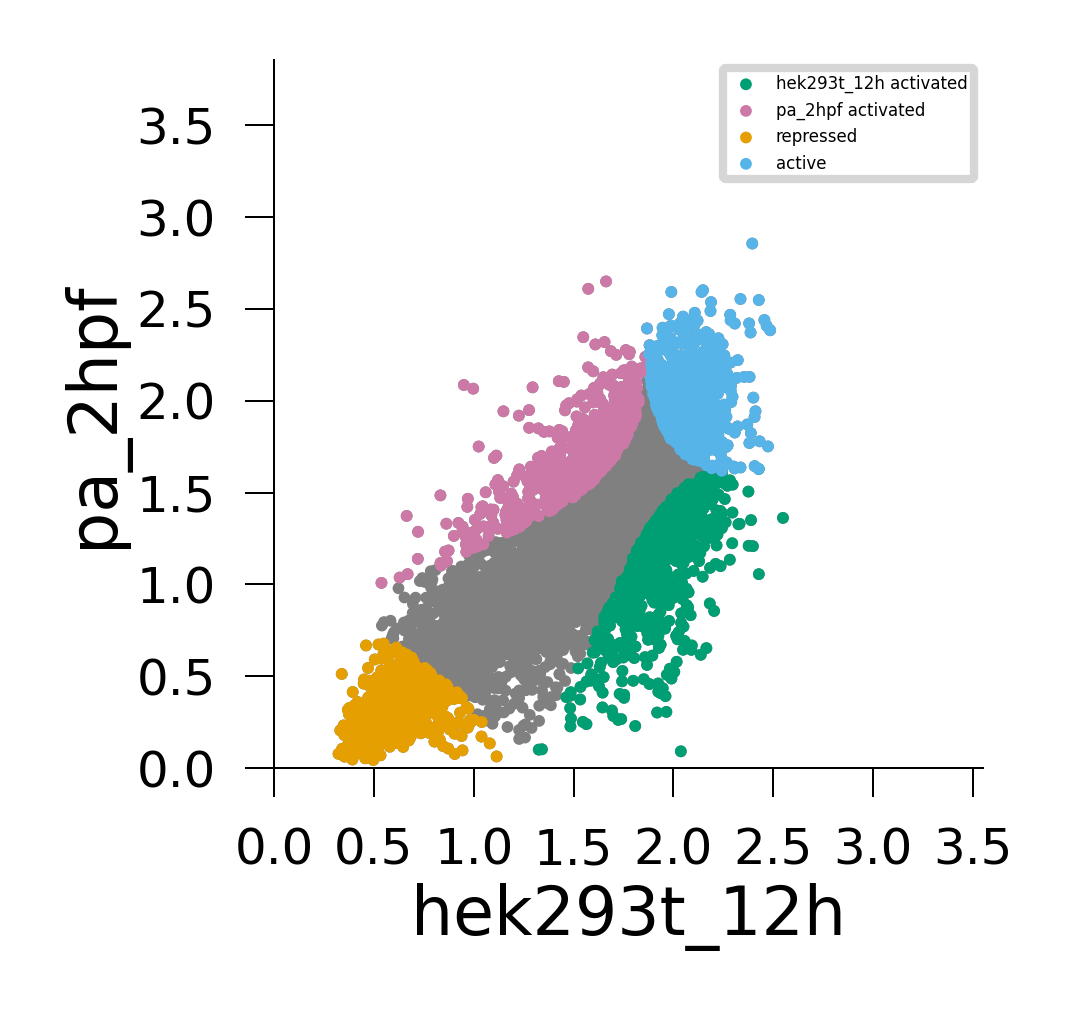

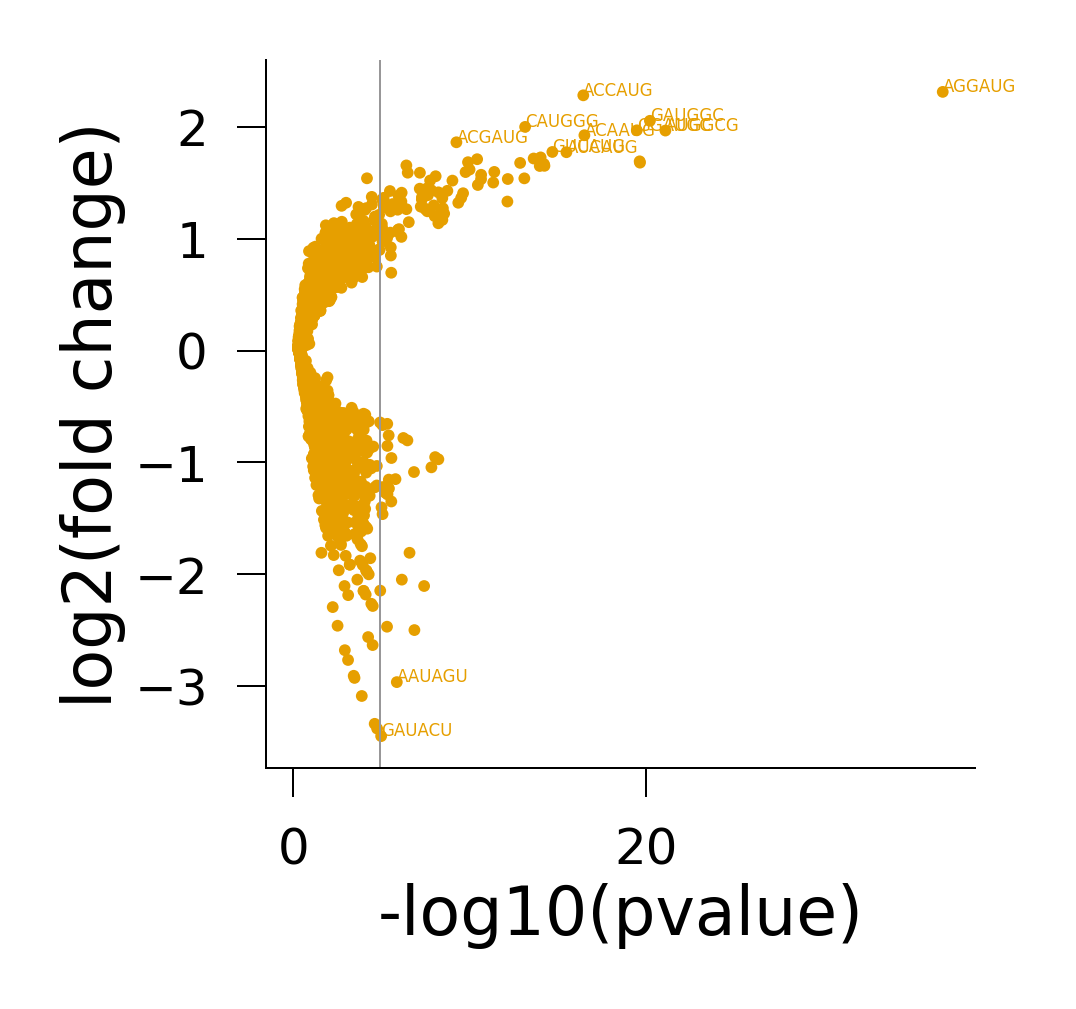

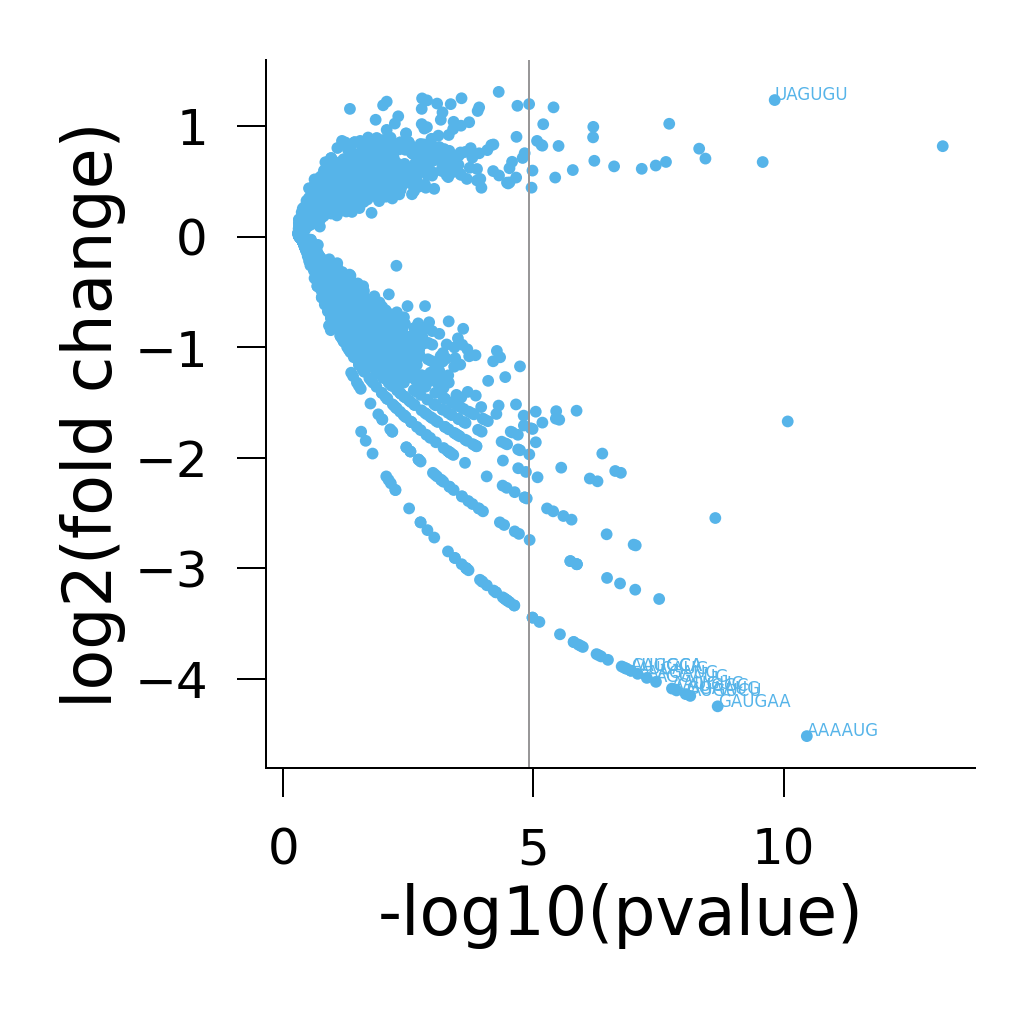

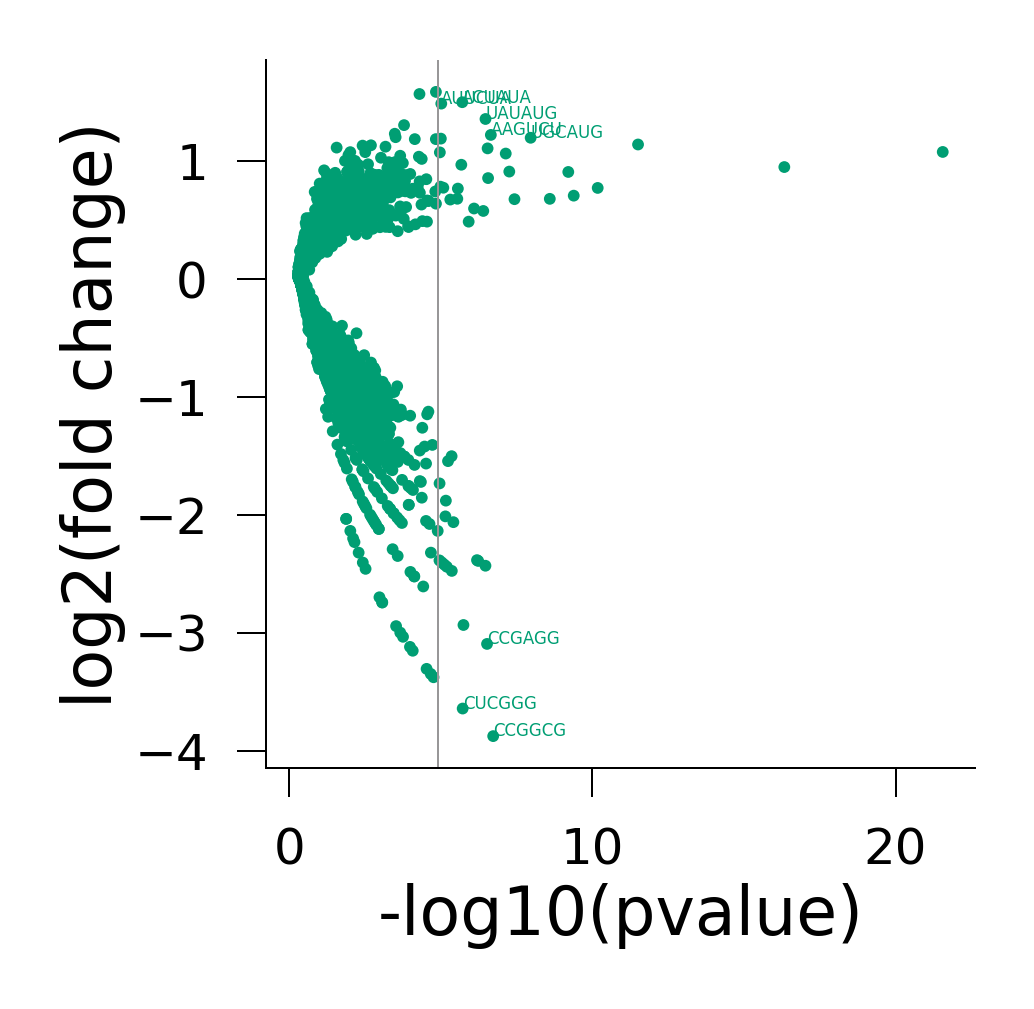

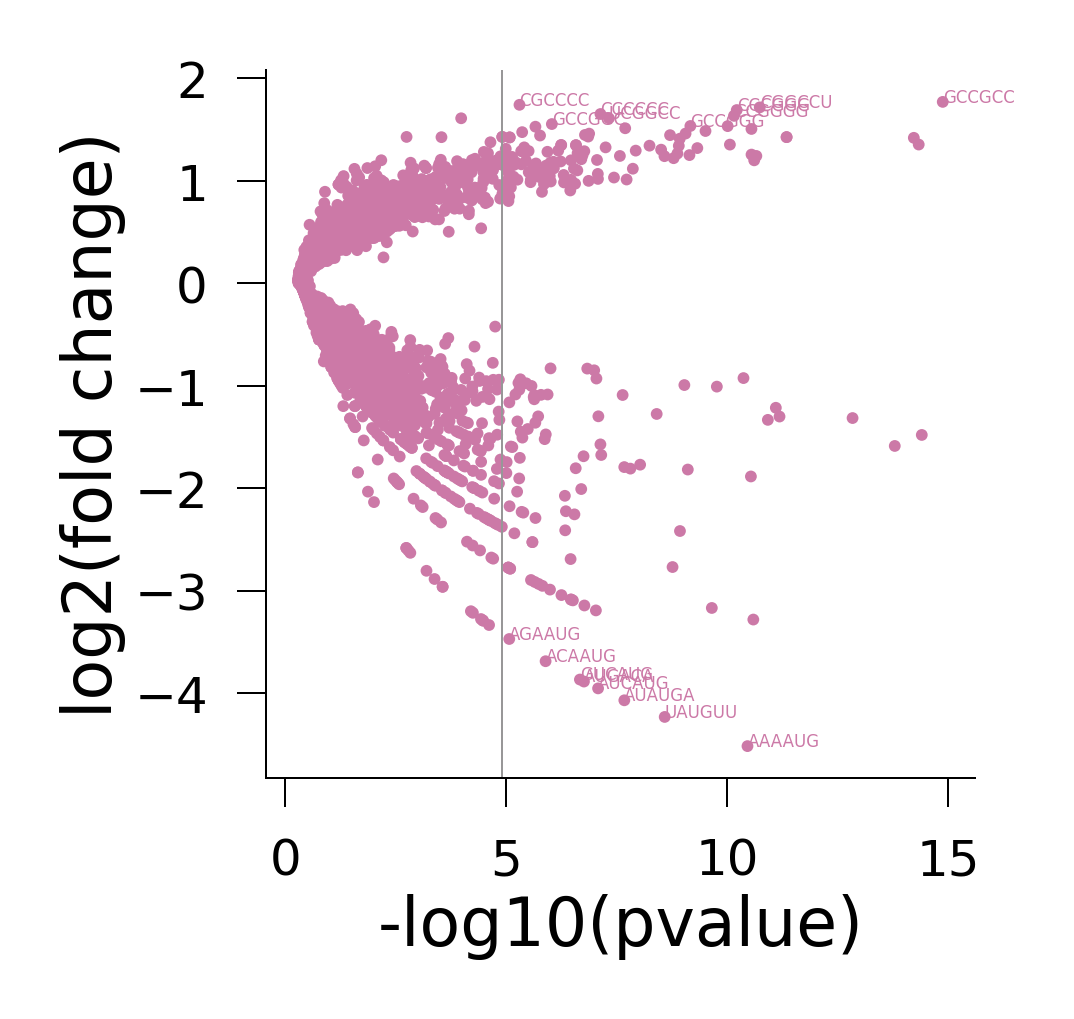

In [4]:
enrichment_df = plot_enrichment.plot_enrichment(db,reporter_group_name='polyA_fish_hek293t',sample_names=['hek293t_12h','pa_2hpf'],fig_save_path=os.getcwd())

In [ ]:
enrichment_df 

,reporter_group_name,feature_name,enrichment_pvalue,enrichment_fold_change
0,pa_2hpf-translation,AAACAT,0.574426,0.993847
1,pa_2hpf-translation,AAATAG,0.996998,0.460205
2,pa_2hpf-translation,AACATG,0.158043,1.037029
3,pa_2hpf-translation,AAGGAA,0.369203,1.075090
4,pa_2hpf-translation,AAGGGC,0.371578,1.012475
...,...,...,...,...
73530,s1_pa_6hpf-translation-s2_hek293t_12h-translation,CGTACC,0.866692,0.588891
73531,s1_pa_6hpf-translation-s2_hek293t_12h-translation,ACTCTA,0.590559,0.968821
73532,s1_pa_6hpf-translation-s2_hek293t_12h-translation,CCATAC,0.375509,1.187763
73533,s1_pa_6hpf-translation-s2_hek293t_12h-translation,AGGGTC,0.046213,1.570376


If the function is provided a single `sample_name` (and the sample is present in the `reporter_group`), then it plots a histogram to visualise the active and repressed enrichment groups respectively

0.1


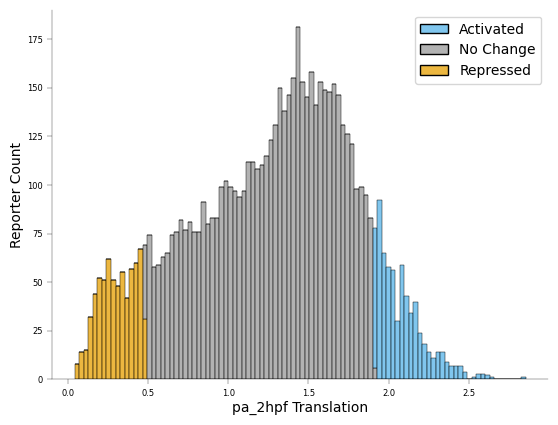

/home/FCAM/smadhavan/naptrap_protocol/src/mpradb/db_plot/plotter.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s = s, alpha = alpha, c = c, edgecolor = edgecolor, cmap = cmap, rasterized= rasterized,label=scatter_label)
/home/FCAM/smadhavan/naptrap_protocol/src/mpradb/db_plot/plotter.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s = s, alpha = alpha, c = c, edgecolor = edgecolor, cmap = cmap, rasterized= rasterized,label=scatter_label)


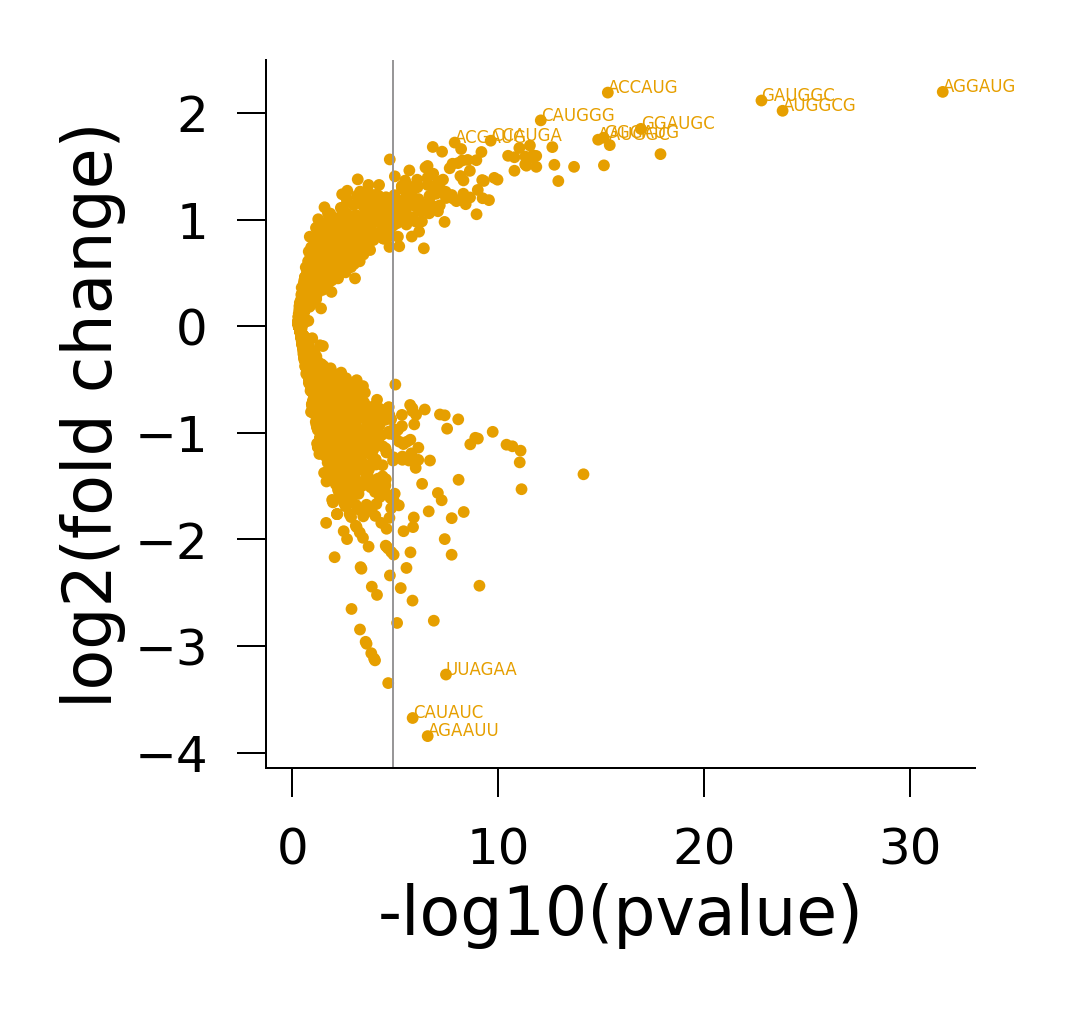

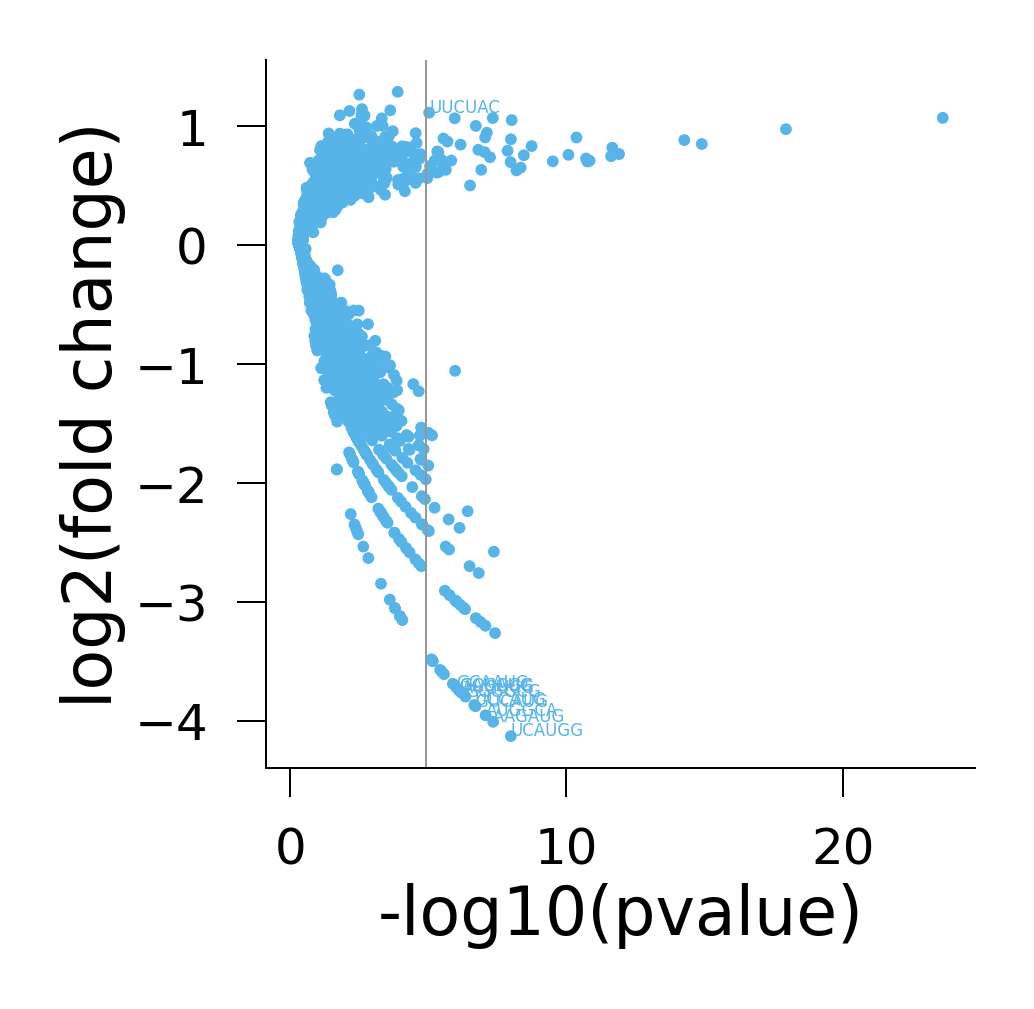

In [ ]:
enrichment_df = plot_enrichment.plot_enrichment(db,reporter_group_name='polyA_fish',fig_save_path=os.getcwd(),fig_save_format='pdf',sample_names=['pa_2hpf'])

## Replicate Plots

To visualise the correlation between replicates to examine the consistency between them, we can plot the replicate scatter plot with the `plot_replicates` function

The function needs to be specified a `selector_name` (name of a selector to use) and optionally a list/string of the sample/s to plot within the selector

array([[1.98309164, 1.98767898, 3.07203759, 3.40950885],
       [1.47574623, 1.59630531, 2.557805  , 2.5653956 ],
       [1.56376902, 1.51233338, 1.71983989, 2.12162206],
       ...,
       [1.46421358, 1.64293368, 2.68438188, 3.10082071],
       [1.28574065, 1.2375435 , 2.45893406, 2.64909141],
       [1.7191691 , 2.02341053, 3.56460058, 4.13392477]])

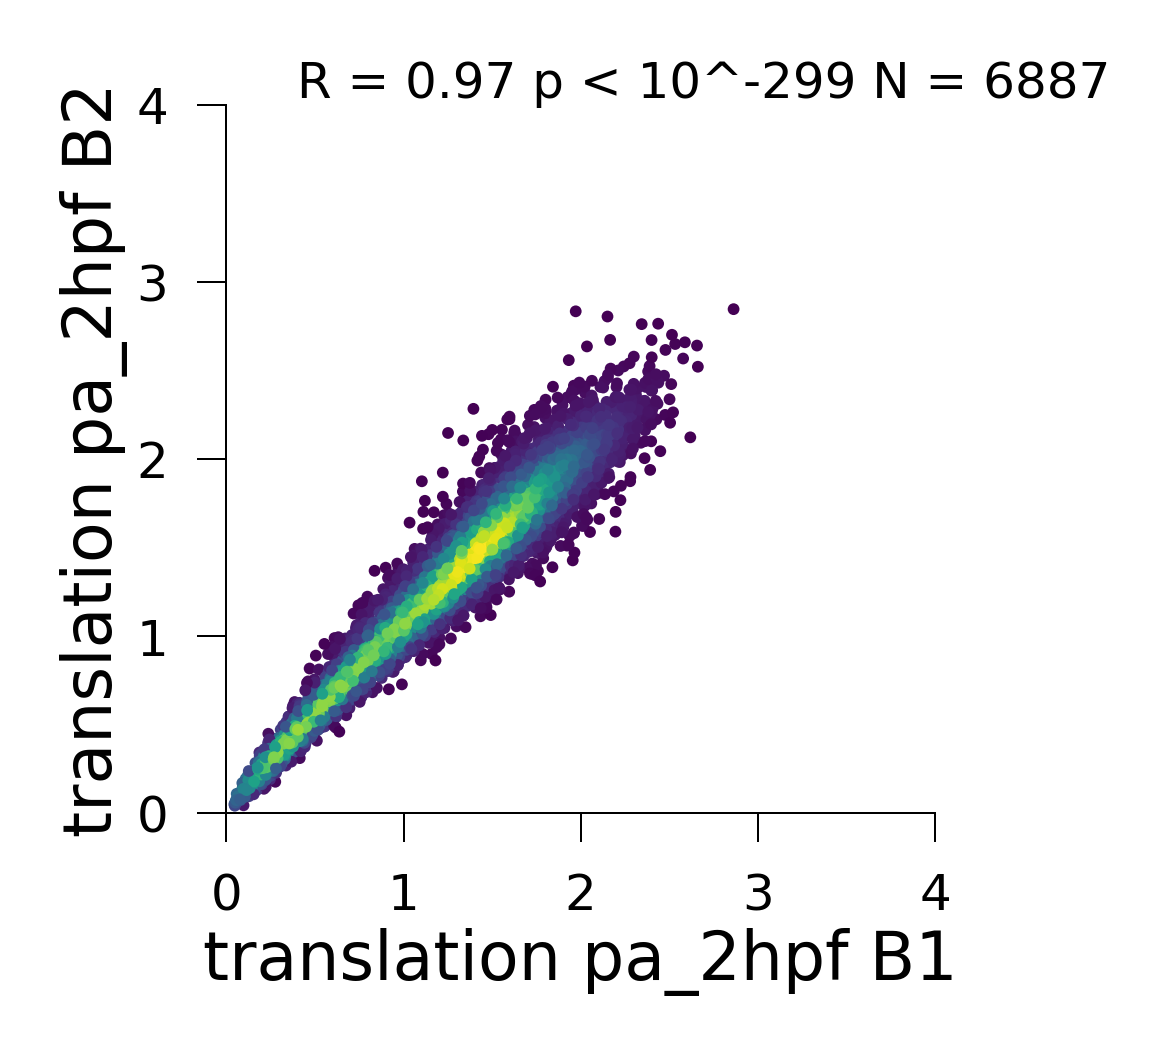

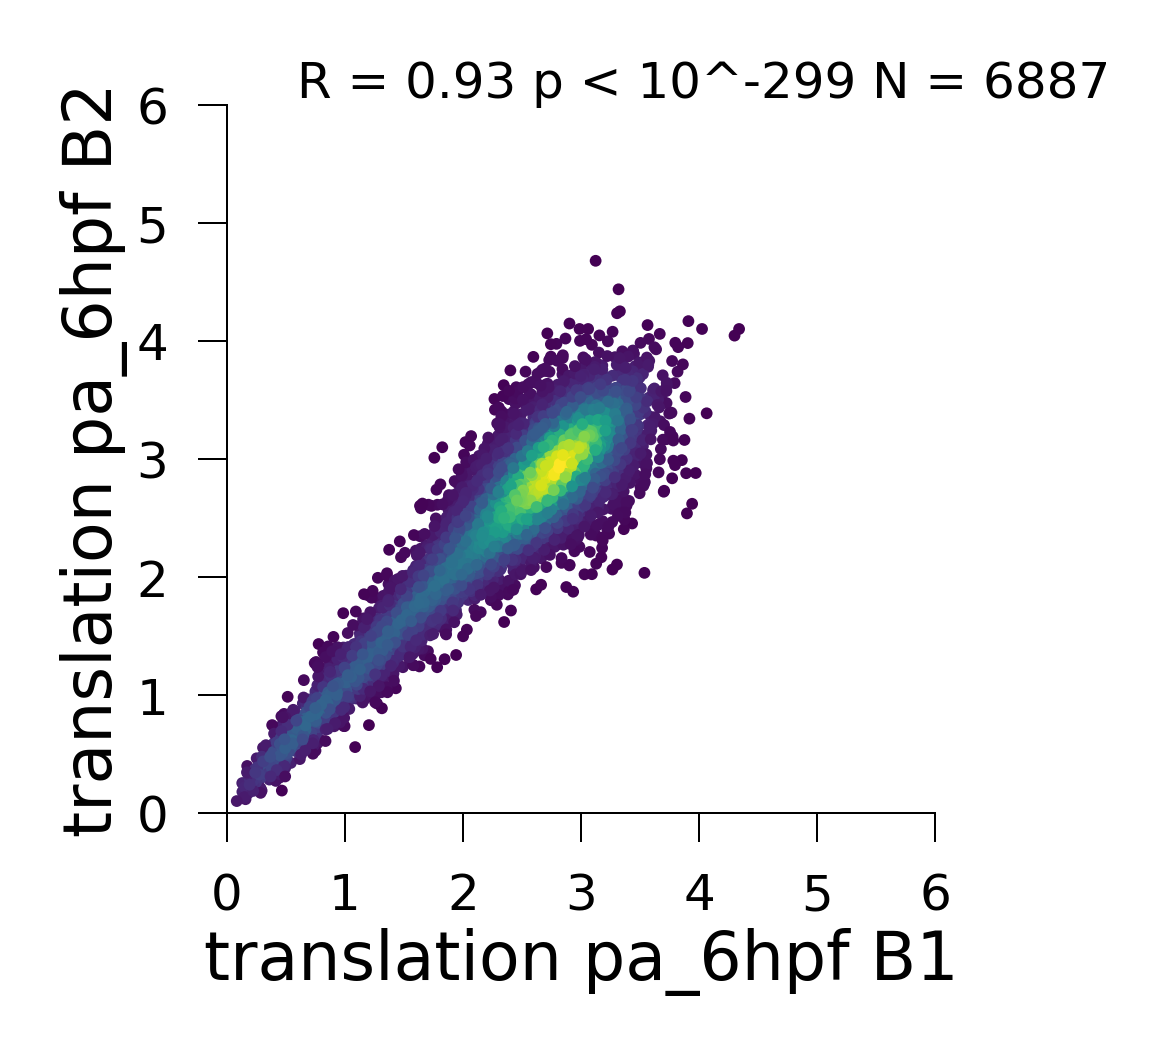

In [ ]:
plot_replicates.plot_replicates(db=db,selector_name='polyA_fish',sample_names=None,fig_save_format='pdf',output_path=os.getcwd())



We can also plot the replicate heatmap which shows the correlation between the replicates across samples for a given `reporter_group_name` (same as selector name). We can also specify the list/string of sample/s to analyse

1 ['hek293t_12h', 'pa_2hpf', 'pa_6hpf']
{0, 1, 2}
6661
10677
6661
{0, 1, 2, 3, 4, 5, 6, 7}


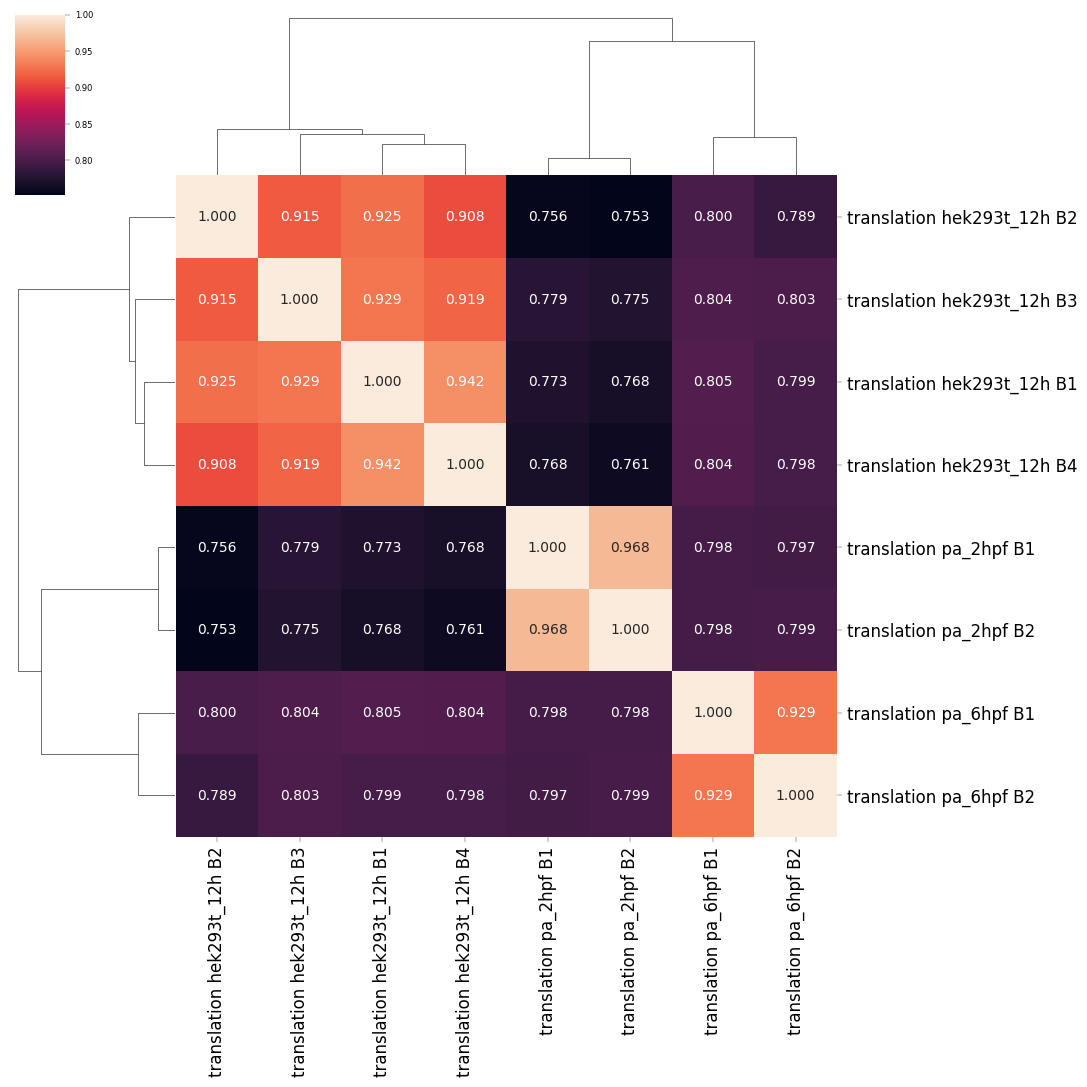

In [ ]:
df = plot_replicate_heatmap.plot_replicate_heatmap(db=db,reporter_group_name='polyA_fish_hek293t',fig_save_format='pdf',sample_names=None,output_path=os.getcwd())

# END